<h1> Материалы курса "Анализ данных в инфромационной безопасности" </h1>

<h2> Практическое занятие № 5.1 </h2>

<h2> Тема: "Классификация спама" </h2>

<h2>Автор:</h2>

<p>Русинова Залина</p>
<p>Младший исследователь исследовательского центра UDV Group</p>
<p>zalina.rusinova@udv.group</p>

In [1]:
import pandas as pd
import numpy as np
import re
import string
import spacy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 12.8/12.8 MB 5.0 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## Оглавление <a name='toc'></a>
<ol>
<li><a href='#load'> Загрузка и подготовка данных</a></li>
<li><a href='#bow'>Bag of Words</a></li>
<li><a href='#tfidf'>Tf-Idf</a></li>
<li><a href='#interp'>Интерпретация</a></li>
</ol>

### 1. Загрузка и подготовка данных <a name='load'></a>

In [3]:
data = pd.read_csv('spam.csv', encoding='iso-8859-1')[['v1', 'v2']].rename(columns={'v1': 'label', 'v2': 'text'})
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
data['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [5]:
data['label'] = data['label'].map({'ham': 0, 'spam': 1})

## Предобработка данных

### 1 вариант предобрабоки:

Создадим пайплан обработки данных вручную с использованием библиотек pymorphy2 и nltk:

1. **Токенизация** — самый первый шаг при обработке текста. 
2. **Нормализация** — приведение к одному регистру, удаляются пунктуации, исправление опечаток и т.д.
3. 
    * **Стемминг** —  выделение псевдоосновы слова.
    * **Лемматизация** — приведение слов к словарной ("начальной") форме.
4. **Удаление стоп-слов** — слов, которые не несут никакой смысловой нагрузки (предлоги, союзы и т.п.) Список зависит от задачи!

**Важно!** Не всегда нужны все этапы, все зависит от задачи!

### NLP-библиотеки

NLP-библиотеки для питона:
* Natural Language Toolkit (NLTK)
* Apache OpenNLP
* Stanford NLP suite
* Gate NLP library
* Spacy
* Yargy
* DeepPavlov
* CLTK (для древних языков)
* и т.д.

Самая старая и известная — NLTK. В NLTK есть не только различные инструменты для обработки текста, но и данные — текстовые корпуса, предобученные модели для анализа тональности и морфологической разметки, списки стоп-слов для разных языков и т.п.

* [Учебник по NLTK](https://www.nltk.org/book/) от авторов библиотеки и [тьюториалы](https://github.com/hb20007/hands-on-nltk-tutorial) по решению разных задач NLP с помощью NLTK.
* [Документация Spacy](https://spacy.io/)
* [Документация Yargy](https://yargy.readthedocs.io/)
* [Документация DeepPavlop](http://docs.deeppavlov.ai/)

In [6]:
import re
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords

m = MorphAnalyzer()
regex = re.compile("[А-Яа-яA-z]+")

Этап 1 - Нормализация текста. Удаляем пунктуацию и числа, приводим к нижнему регистру

In [7]:
def words_only(text, regex=regex):
    try:
        return regex.findall(text.lower())
    except:
        return []

<ins>Удаление стоп-слов</ins>

**Стоп-слова** — высокочастотные слова, которые не дают нам никакой информации о конкретном тексте. Они составляют верхушку частотного списка в любом языке. Набор стоп-слов не универсален, он будет зависеть от вашей задачи!

В NLTK есть готовые списки стоп-слов для многих языков.

In [8]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zrusinova\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
mystopwords = stopwords.words('english') 
def remove_stopwords(lemmas, stopwords = mystopwords):
    return [w for w in lemmas if not w in stopwords and len(w) > 3]

<ins>Лемматизация</ins>

**Лемматизация** — процесс приведения словоформы к лемме, т.е. нормальной (словарной) форме. Это более сложная задача, чем стемминг, но и результаты дает гораздо более осмысленные, особенно для языков с богатой морфологией.

* кошке, кошку, кошкам, кошкой $\implies$ кошка
* бежал, бежит, бегу $\implies$  бежать
* белому, белым, белыми $\implies$ белый

###  pymorphy2

**pymorphy2** — это полноценный морфологический анализатор, целиком написанный на Python. В отличие от Mystem, он не учитывает контекст, а значит, вопрос разрешения омонимии надо будет решать нам самим (об этом ниже). Он также умеет ставить слова в нужную форму (спрягать и склонять). 

[Документация pymorphy2](https://pymorphy2.readthedocs.io/en/latest/)

In [10]:
def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form

def lemmatize_text(text):
    return [lemmatize_word(w) for w in text]

Собираем пайплайн

In [11]:
def clean_text(text):
    tokens = words_only(text)
    lemmas = lemmatize_text(tokens)
    
    return ' '.join(remove_stopwords(lemmas))
lemmas = list(map(clean_text, data['text']))
    
data['cleaned_text'] = lemmas
data.sample(5)

,label,text,cleaned_text
4962,0,I want to see your pretty pussy...,want pretty pussy
656,0,Sun cant come to earth but send luv as rays. c...,cant come earth send rays cloud cant come rive...
5086,0,Omg if its not one thing its another. My cat h...,thing another worms
2275,0,Is that on the telly? No its Brdget Jones!,telly brdget jones
4504,1,Mobile Club: Choose any of the top quality ite...,mobile club choose quality items mobile cfca


### 2 вариант предобрабоки:

Использование готового пайплайна предобработки текста из библиотеки spacy.

**Spacy** - это библиотека расширенной обработки естественного языка (NLP) с открытым исходным кодом на Python. Библиотека spaCy выделяется своей эффективностью и производительностью. Она разработана с акцентом на скорость и точность, что делает ее предпочтительным выбором для многих разработчиков и исследователей в области NLP.

Пайпланы обработки в **spacy** - это последовательность обработки компонентов текста. Пайплан обычно включает в себя теггер, лемматизатор, синтаксический анализатор и распознаватель сущностей. Каждый компонент конвейера возвращает обработанный документ, который затем передается следующему компоненту. 

<img src="https://spacy.io/images/pipeline.svg" alt="pipeline.png" style="width: 600px;"/>

Доспупные компоненты пайплана:

| Название |    Компонент    |   Результат    |           Описание           |
|----------|-----------------|----------------|------------------------------|
|tokenizer |    Tokenizer    |      Doc       |Сегаментирует текст на токены |
|tagger    |     Tagger      |   Token.tag    |Назначает POS-теги            |
|parser    | DependencyParser|   Token.head,  |Назначает лейблы зависимостей |
|          |                 |   Token.dep,   |                              |
|          |                 |   Doc.sents,   |                              |
|          |                 |Doc.noun_chunks |                              |
|ner       | EntityRecognizer|   Doc.ents,    |Размещает именованные сущности|
|          |                 | Token.ent_iob, |                              |
|          |                 | Token.ent_type |                              |
|lemmatizer|   Lemmatizer    |   Token.lemma  |Определяет базовую форму      |
|textcat   | TextCategorizer |   Doc.cats     |Назначает лейблы документа    |
|custom    |custom components|    custom      |Назначает кастомные аттрибуты |

In [14]:
nlp = spacy.load("en_core_web_sm")
stopwords = nlp.Defaults.stop_words
print(f'Spacy english stopwords size: {len(stopwords)}', end='\n\n')
' '.join(stopwords)

Spacy english stopwords size: 326



"whole have move nor towards mostly least too make seeming latter these several had am 've alone a since various always back me myself most does neither during ’ll n't rather show whether nobody per whence regarding hereby as even ‘s do ever less ‘ve in so into whenever part ourselves together around us seem serious be though last it and also whereas much might sometime we call between until otherwise must take nevertheless front hereafter hereupon re thereby due via thru whither 's down your first no this made else ten on why however therefore upon were done cannot about without will ours beside thereupon five noone was give top empty its not my there becomes somewhere already few through four 'm 'd himself forty such unless just latterly thereafter put may within used our hundred anyhow when really hers if under enough whereafter both how could that three who onto herself herein amongst them say twenty toward wherever his 'll among mine seemed nowhere everywhere whom only thus been ‘

In [15]:
%%time

data['cleaned_text2'] = data['text'].apply(
    lambda x: ' '.join(
        token.lemma_.lower() for token in nlp(x) if
        not token.is_stop
        and not token.is_punct
        and not token.is_digit
        and not token.like_email
        and not token.like_num
        and not token.is_space
    )
)
data.sample(5)

Wall time: 28.9 s


,label,text,cleaned_text,cleaned_text2
5376,0,I don't want you to leave. But i'm barely doin...,want leave barely stay sane fighting constantl...,want leave barely stay sane fight constantly help
2190,0,"Ooh, 4got, i'm gonna start belly dancing in mo...",gonna start belly dancing moseley weds want jo...,ooh 4got gon na start belly dance moseley wed ...
4197,1,Want to funk up ur fone with a weekly new tone...,want funk fone weekly tone reply tones text ri...,want funk ur fone weekly new tone reply tones2...
509,0,Your opinion about me? 1. Over 2. Jada 3. Kusr...,opinion jada kusruthi lovable silent character...,opinion jada kusruthi lovable silent spl chara...
1906,0,And stop being an old man. You get to build sn...,stop build snowman snow angels snowball fights,stop old man build snowman snow angel snowball...


In [16]:
data['cleaned_text2'].iloc[3]

'u dun early hor u c'

### 2. Bag of Words <a name='load'></a>

#### CountVectorizer

- приводит к нижнему регистру
- проводит токенизацию - `r"(?u)\b\w\w+\b"` (токены из 2 или более буквенно-цифровых символов, пунктуация полностью игнорируется и всегда рассматривается как разделитель токенов)
  - `(?u)` - флаг Unicode
  - `\b` - граница слова
  - `\w` - символы, которые могут входить в состав слов, включая числа и подчёркивание
  - `\+` - 1 и более повторений предшествующего выражения
- фильтрует стоп-слова

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS

In [20]:
print(f'Sklearn english stopwords size: {len(ENGLISH_STOP_WORDS)}', end='\n\n')
' '.join(ENGLISH_STOP_WORDS)

Sklearn english stopwords size: 318



'whole have move nor towards mostly least too mill seeming latter these several had am alone a since cry always back me myself most neither during rather show whether nobody per whence hereby as even do ever less in so into whenever part ourselves together around us seem serious be though last found and it also whereas much might sometime we call between until otherwise must take nevertheless front hereafter hereupon re thereby due via thru whither down your first no this made else fill ten on why however therefore upon were done cannot about without will ours bill beside thereupon five noone was give top co empty its not my there becomes somewhere already few through four hasnt himself forty such latterly thereafter put may within our hundred anyhow when cant hers de if under enough whereafter both how con could that three who onto thick un herself system herein amongst them twenty toward wherever his among interest mine seemed nowhere everywhere whom only thus been inc eleven thin be

In [16]:
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_text'], data['label'], random_state=2023)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_text2'], data['label'], random_state=2023)

In [22]:
vectorizer = CountVectorizer(max_df=0.7, min_df=0.003) # max_df фильтрует corpus-specific stop words
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [24]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

Бейзлайн

In [25]:
dummy_clf = DummyClassifier(strategy="most_frequent").fit(X_train_vectorized, y_train)
preds = dummy_clf.predict(X_test_vectorized)
print(classification_report(y_test, preds, zero_division=0))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1207
           1       0.00      0.00      0.00       186

    accuracy                           0.87      1393
   macro avg       0.43      0.50      0.46      1393
weighted avg       0.75      0.87      0.80      1393



Логистическая регрессия

In [20]:
logreg = LogisticRegression().fit(X_train_vectorized, y_train)
preds = logreg.predict(X_test_vectorized)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1207
           1       0.96      0.78      0.86       186

    accuracy                           0.97      1393
   macro avg       0.96      0.89      0.92      1393
weighted avg       0.97      0.97      0.96      1393



In [26]:
logreg = LogisticRegression().fit(X_train_vectorized, y_train)
preds = logreg.predict(X_test_vectorized)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1207
           1       0.97      0.82      0.89       186

    accuracy                           0.97      1393
   macro avg       0.97      0.91      0.94      1393
weighted avg       0.97      0.97      0.97      1393



### 3. Tf-Idf <a name='tfidf'></a>

В объемном корпусе некоторые слова будут присутствовать в большом количестве документов (текстов), а значит, они несут очень мало значимой информации о фактическом содержании документа.

Для решения этой проблемы можно использовать Tf-Idf подход

Цель использования tf-idf состоит в том, чтобы уменьшить влияние токенов, которые очень часто встречаются в данном корпусе и, следовательно, эмпирически менее информативны, чем признаки, которые встречаются малой части корпуса


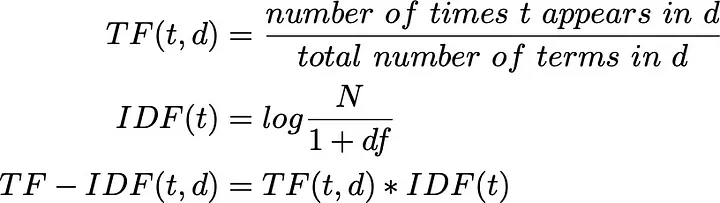

In [18]:
from sklearn.feature_extraction.text import TfidfTransformer,  TfidfVectorizer
from sklearn.pipeline import Pipeline

**TfidfTransformer** преобразует матрицу из CountVectorizer в tf-idf

In [19]:
pipe = Pipeline(
    steps=[
        ('counter', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegression())
    ]
).fit(X_train, y_train)
preds = pipe.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1207
           1       0.99      0.70      0.82       186

    accuracy                           0.96      1393
   macro avg       0.97      0.85      0.90      1393
weighted avg       0.96      0.96      0.96      1393



**TfidfVectorizer** работает end-to-end

In [ ]:
pipe = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer()),
        ('clf', LogisticRegression())
    ]
).fit(X_train, y_train)
preds = pipe.predict(X_test)
print(classification_report(y_test, preds))

#### Оптимизация гиперпараметров пайплайна целиком - HalvingGridSearchCV

In [20]:
pipe = Pipeline(
    steps=[
        ('counter', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegression())
    ]
)

In [21]:
parameter_grid = {
    "counter__max_df": np.linspace(0.3, 0.7, 10),
    "counter__min_df": [0.0, 0.001, 0.003, 0.005],
    "counter__ngram_range": ((1, 1), (1, 2)),  # слова или биграммы
    "tfidf__norm": ("l1", "l2"),
    "clf__C": np.linspace(0.1, 1, 10),
}

In [22]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [23]:
%%time

grid_search = HalvingGridSearchCV(
    pipe,
    param_grid=parameter_grid,
    n_jobs=-1,
    verbose=1,
    cv=2,
    scoring='accuracy',
    random_state=42,
)
grid_search.fit(X_train, y_train)

n_iterations: 6
n_required_iterations: 7
n_possible_iterations: 6
min_resources_: 8
max_resources_: 4179
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1600
n_resources: 8
Fitting 2 folds for each of 1600 candidates, totalling 3200 fits


C:\Users\zrusinova\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
1760 fits failed out of a total of 3200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\zrusinova\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\zrusinova\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\zrusinova\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 348, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C

----------
iter: 1
n_candidates: 534
n_resources: 24
Fitting 2 folds for each of 534 candidates, totalling 1068 fits


C:\Users\zrusinova\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.78787879 0.78787879 0.78787879]
  warnings.warn(
C:\Users\zrusinova\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the train scores are non-finite: [       nan        nan        nan ... 0.78787879 0.78787879 0.78787879]
  warnings.warn(


----------
iter: 2
n_candidates: 178
n_resources: 72
Fitting 2 folds for each of 178 candidates, totalling 356 fits


C:\Users\zrusinova\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.84563492 0.84563492 0.84563492]
  warnings.warn(
C:\Users\zrusinova\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the train scores are non-finite: [       nan        nan        nan ... 0.84563492 0.84563492 0.84563492]
  warnings.warn(


----------
iter: 3
n_candidates: 60
n_resources: 216
Fitting 2 folds for each of 60 candidates, totalling 120 fits


C:\Users\zrusinova\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.84185704 0.84185704 0.84185704]
  warnings.warn(
C:\Users\zrusinova\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the train scores are non-finite: [       nan        nan        nan ... 0.84185704 0.84185704 0.84185704]
  warnings.warn(


----------
iter: 4
n_candidates: 20
n_resources: 648
Fitting 2 folds for each of 20 candidates, totalling 40 fits


C:\Users\zrusinova\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.85628559 0.85628559 0.86557352]
  warnings.warn(
C:\Users\zrusinova\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the train scores are non-finite: [       nan        nan        nan ... 0.85628559 0.85628559 0.8825345 ]
  warnings.warn(
C:\Users\zrusinova\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.86310303 0.86310303 0.93052324]
  warnings.warn(
C:\Users\zrusinova\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the train scores are non-finite: [       nan        nan        nan ... 0.86310303 0.86310303 0.9500748 ]
  warnings.warn(


----------
iter: 5
n_candidates: 7
n_resources: 1944
Fitting 2 folds for each of 7 candidates, totalling 14 fits
Wall time: 11.5 s


HalvingGridSearchCV(cv=2,
                    estimator=Pipeline(steps=[('counter', CountVectorizer()),
                                              ('tfidf', TfidfTransformer()),
                                              ('clf', LogisticRegression())]),
                    n_jobs=-1,
                    param_grid={'clf__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                'counter__max_df': array([0.3       , 0.34444444, 0.38888889, 0.43333333, 0.47777778,
       0.52222222, 0.56666667, 0.61111111, 0.65555556, 0.7       ]),
                                'counter__min_df': [0.0, 0.001, 0.003, 0.005],
                                'counter__ngram_range': ((1, 1), (1, 2)),
                                'tfidf__norm': ('l1', 'l2')},
                    random_state=42, scoring='accuracy', verbose=1)

In [24]:
plt.rcParams["figure.figsize"] = (12, 8)

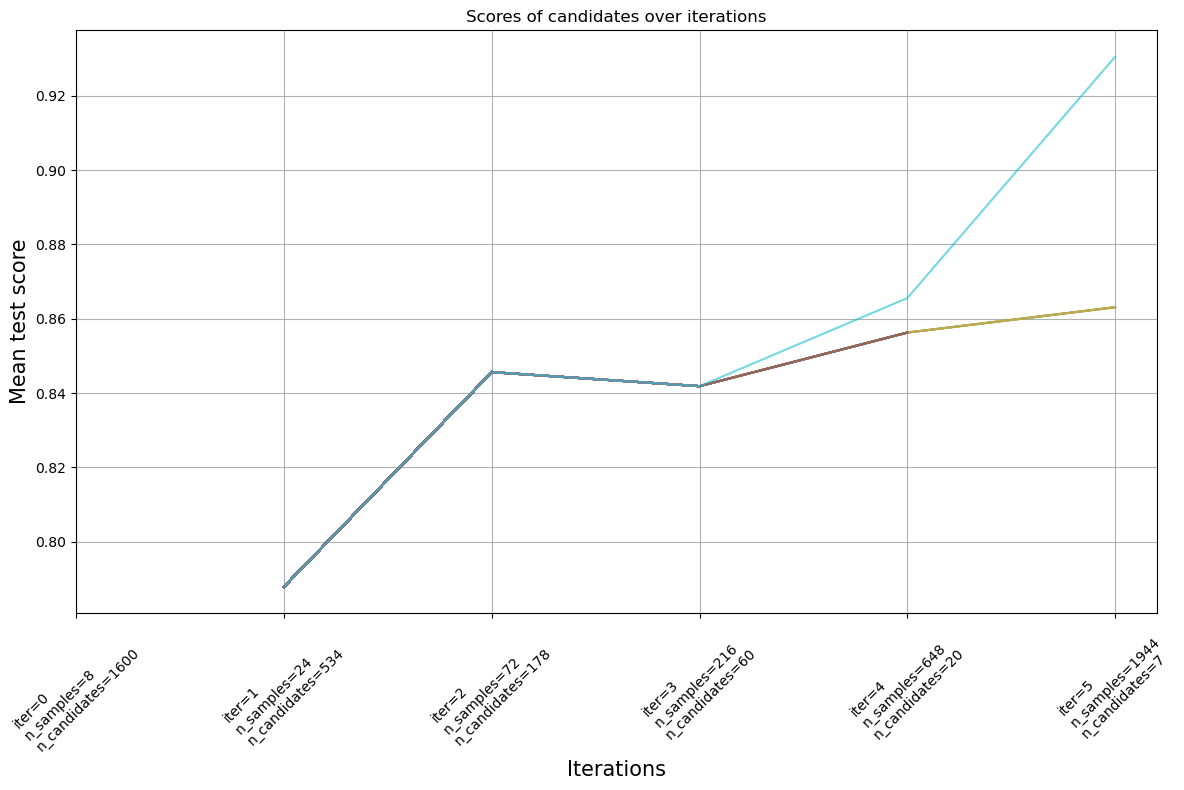

In [25]:
results = pd.DataFrame(grid_search.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter",
    columns="params_str",
     values="mean_test_score",
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={grid_search.n_resources_[i]}\nn_candidates={grid_search.n_candidates_[i]}"
    for i in range(grid_search.n_iterations_)
]

ax.set_xticks(range(grid_search.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("Mean test score", fontsize=15)
ax.set_xlabel("Iterations", fontsize=15)
plt.tight_layout()
plt.grid()
plt.show()

In [26]:
grid_search.best_score_

0.9305232397977563

In [27]:
preds = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1207
           1       0.99      0.77      0.87       186

    accuracy                           0.97      1393
   macro avg       0.98      0.89      0.92      1393
weighted avg       0.97      0.97      0.97      1393



### 4. Интерпретация <a name='interp'></a>

**ELI5** – это библиотека в Python, которая позволяет визуализировать и отлаживать различные модели машинного обучения с помощью унифицированного API. Она имеет встроенную поддержку для нескольких ML-фреймворков и обеспечивает способы интерпретации black-box модели.

In [28]:
!pip install eli5

     ------------------------------------ 216.2/216.2 kB 346.8 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107728 sha256=9fb6e57487347467c2851ed876d4a6cc6392fda292fa4a2dcb22105e54eefc8a
  Stored in directory: c:\users\zrusinova\appdata\local\pip\cache\wheels\7b\26\a5\8460416695a992a2966b41caa5338e5e7fcea98c9d032d055c
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3


In [29]:
import eli5

In [30]:
grid_search.best_estimator_['clf']

LogisticRegression()

In [31]:
eli5.show_weights(
    estimator=grid_search.best_estimator_['clf'],
    feature_names= list(grid_search.best_estimator_['counter'].get_feature_names_out()),
    top=(50, 5)
)

Weight?,Feature
+4.360,txt
+3.852,claim
+3.710,mobile
+3.430,www
+3.285,150p
+3.214,win
+3.072,free
+3.038,service
+2.980,stop
+2.855,chat
